In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from tensorflow import keras
import tensorflow as tf
import os,datetime
import tensorflow_datasets as tfds

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
df, info = tfds.load('patch_camelyon', with_info = True, as_supervised = True)

In [5]:
train_data = df['train']
test_data = df['test']

In [6]:
def preprocess(image, labels):
  image = tf.cast(image, tf.float32)
  image /= 255.
  return image, labels
train_data = train_data.map(preprocess)
test_data = test_data.map(preprocess)
buffer_size = 1000
train_data = train_data.shuffle(buffer_size)
batch_size = 128
train_data = train_data.batch(batch_size).prefetch(1)
test_data = test_data.batch(batch_size).prefetch(1)

In [7]:
train_images,train_labels=next(iter(train_data))
test_images,test_label=next(iter(test_data))

In [8]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
def create_model():
    model = Sequential([
        Flatten(input_shape=(96, 96, 3)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import optimizers
for fold, (train_index, val_index) in enumerate(skf.split(train_images, train_labels)):
    X_train_fold, X_val_fold = train_images.numpy()[train_index], train_images.numpy()[val_index]
    y_train_fold, y_val_fold = train_labels.numpy()[train_index], train_labels.numpy()[val_index]
    # Create and compile the model
    model = create_model()
    history = model.fit(X_train_fold, y_train_fold, epochs=100, validation_data=(X_val_fold, y_val_fold), verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Fold {fold + 1}, Validation Accuracy: {val_accuracy * 100:.2f}%')

Fold 1, Validation Accuracy: 69.23%
Fold 2, Validation Accuracy: 61.54%
Fold 3, Validation Accuracy: 46.15%
Fold 4, Validation Accuracy: 68.00%
Fold 5, Validation Accuracy: 56.00%


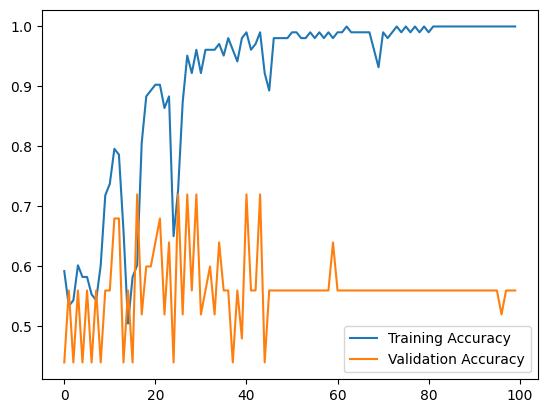

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()